#### cluster-specific setup, adjust this according to your own ###

In [ ]:
# start a new Spark session, necessary for all Spark-related operations
from pyspark.sql import SparkSession

# 'spark' and 'sc' are the canonical variable names for the SparkSession and SparkContext objects
spark = SparkSession.builder\
    .getOrCreate()

sc = spark.sparkContext
spark

In [ ]:
# point here to where the workshop's data folder is located
from os import path

DATA_FOLDER = "gs://zw_axolotl/jgi_workshop_2024/data"

In [ ]:
# point here to where we will store results from the activity (make sure it's empty and readable!)

RESULT_FOLDER = "./"

#### variables setup and imports

In [ ]:
from pyspark.sql import functions as F # contain frequently-used functions
from pyspark.sql import types as T # for specifying schema datatypes, etc

# basic python libraries for data manipulation and visualization
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns



### Activity 1-1: Loading tabular file(s) into pySpark DataFrame

In [ ]:
# we will be using pySpark's csv reader (https://spark.apache.org/docs/latest/sql-data-sources-csv.html)

metadata_sdf = (spark.read
    .option("delimiter", "\t")
    .option("header", True)
    .option("inferSchema", True)
    .option("samplingRatio", 0.0001)
    .csv(path.join(DATA_FOLDER, "mgnify-marine-v2-0.tsv"))
)

# when assigned, the variable will not contain the actual data, due to 'lazy loading'
# however, it will already tried to parse the columns information (based on the header)
# and, if 'inferSchema' = True, it will do a pass on the data (based on sampleRatio)
# to determine the data types
metadata_sdf

In [ ]:
# this will tell Spark to parse only the 'first' three rows of the TSV file, then convert to a Pandas DF for visual
# parsing will be done at the workers side, then the resulting rows will be collected in the driver/client side

metadata_sdf.limit(3).toPandas()

#### {!} Important: pandas (and numpy or list) have the concept of _inherent row ordering_, while Spark does not.** i.e., you can slice a pandas dataframe by doing df.iloc[1:100] while you can't do that with a Spark DataFrame.

even though you can collect first N rows into the driver via show(n) or take(n), it will not always return the same result every time, and you can't do something like df["column_a"] = [1,2,3,4,5]. Do you know why?



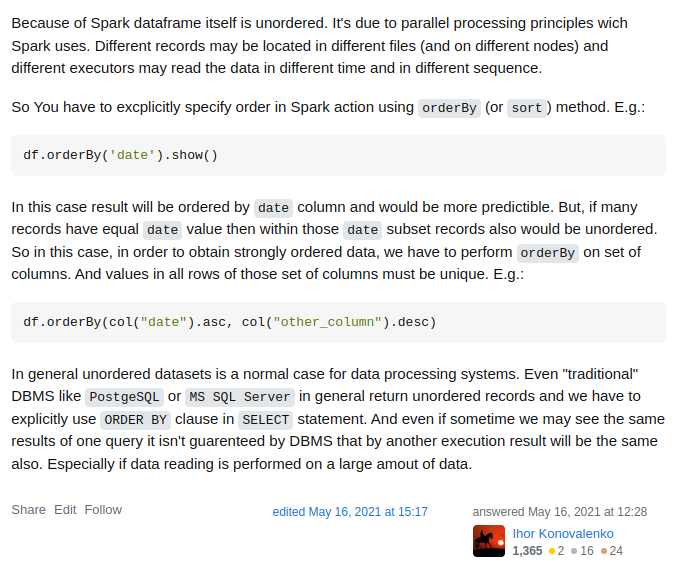

#### {!} Important: always work with the PERSISTED final form of the DataFrame you want to use

When you assign a read.csv() operation diretly into a python variable like above, *Spark will perform the parsing operation (and any other operations) **every single time** that the DataFrame is evaluated* (i.e., via a show() or count() or toPandas()), wasting valuable time and resources.

*Because of how easy it is to work with Spark DF code-wise, we tend to forget the scale of the operation we are dealing with and end up with an inefficient code.*

A good practice to work with Spark DataFrame is to **persist the final pre-processed form (one that you want to query and train ML models on)**, then only queries from it. There are three ways to do it:

* **1 & 2** - **persist()** and **cache()** when you only need the pre-processed dataframe for one runtime

* **3** - **storing to Parquet** when you will need the pre-processed dataframe multiple times


In the end, consider the final cost of compute time vs storage space

In [ ]:
# this is the actual 'strategy' that Spark will execute to generate the DataFrame everytime it is evaluated
# see the 'Filescan csv', meaning that every time we collect metadata_sdf, it will rerun scanning the csv file
metadata_sdf.explain()

In [ ]:
# we will persist() the metadata (see https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.persist.html)
# and assign it into a new variable

metadata_sdf_persisted = metadata_sdf.select("*")
metadata_sdf_persisted.persist() # mark the dataframe for persisting
%time metadata_sdf_persisted.count() # need to do a one-pass over the data for persisting
metadata_sdf_persisted

In [ ]:
# see how it is different with the above
metadata_sdf_persisted.explain()

### Activity 1-2: things you can do with a Spark DataFrame

In [ ]:
# putting this here to help lookup
metadata_sdf_persisted.limit(3).toPandas()

#### Filtering and counting:

In [ ]:
metadata_sdf_persisted.count() # total: 50,866 rows

In [ ]:
(metadata_sdf_persisted.filter("N_contigs < 100") # select only higher quality MAGs
    .select("Genome", "N_contigs") # reduce the number of columns to be collected into PandasDF
    .toPandas())

#### Creating new columns out of existing ones

In [ ]:
# use withColumn and the combination of functions in the spark.sql.functions module
taxonomy_sdf = (metadata_sdf_persisted
     .withColumn("Kingdom", F.split(F.col("Lineage"), ';')[0])
     .withColumn("Phylum", F.split(F.col("Lineage"), ';')[1])
     .withColumn("Genus", F.split(F.col("Lineage"), ';')[5])
     .withColumn("Species", F.split(F.col("Lineage"), ';')[6])
     .select("Genome", "Kingdom", "Phylum", "Genus", "Species", "GC_content")
)

# this is the original plan, with step-by-step construction of taxonomy_df from metadata_df
taxonomy_sdf.explain()

In [ ]:
# for taxonomy, we are going to persist it by exporting it into Parquet
# later on module_2, we will reuse this table

taxonomy_pq_path = path.join(RESULT_FOLDER, "df_taxonomy.pq")
%time taxonomy_sdf.write.mode("overwrite").parquet(taxonomy_pq_path)
taxonomy_sdf = spark.read.parquet(taxonomy_pq_path)

taxonomy_sdf.limit(5).toPandas()

In [ ]:
# now see how the plan changes --> similar to persisting, this will speed up operation on multi-access scenario
taxonomy_sdf.explain()

#### Summarizing/aggregating rows, then visualize

In [ ]:
gc_per_phyla_df = (taxonomy_sdf.groupBy("Kingdom", "Phylum")
     .agg(
         F.collect_list("GC_content").alias("GCs"),
         F.count(F.col("GC_content")).alias("num_genomes")
     )
     .orderBy("num_genomes", ascending=False)
     .limit(10)
     .toPandas()
).sort_values(["Kingdom", "Phylum"])
gc_per_phyla_df

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.ylim(20, 90);
plt.xticks(rotation=320, ha="left");
plt.boxplot(
    gc_per_phyla_df["GCs"],
    labels = (
        gc_per_phyla_df["Kingdom"] + ";"
        + gc_per_phyla_df["Phylum"] + "\n"
        + "[" + gc_per_phyla_df["num_genomes"].astype(str) + "]"
    )
);

### Activity 1-3: using Spark's SQL-like interface (and the first exercise)

My favorite way to play with Spark's DataFrame is through its SQL-like interface. To do this in Spark, you just need to register the DataFrames you need as "tables", via df.createOrReplaceTempView(). They can then be accessed using **spark.sql(query_string)**

see https://spark.apache.org/docs/latest/sql-programming-guide.html

In [ ]:
# let's assign the original table as 'metadata', and the new taxonomy table as 'taxonomy'
metadata_sdf_persisted.createOrReplaceTempView("metadata")
(taxonomy_sdf.select("Genome", "Kingdom", "Phylum", "Genus", "Species") # don't need the GC value
    .createOrReplaceTempView("taxonomy"))

In [ ]:
# now let's display them, this time using SQL query

spark.sql("SELECT * FROM metadata LIMIT 5").toPandas()

In [ ]:
# inside, it is still the same thing
spark.sql("SELECT * FROM metadata LIMIT 5").explain()

#### Example query (plus introducing the 'JOIN' operation) :

In [ ]:
spark.sql((
    "SELECT printf('%s:%s', substring(Kingdom, 4), substring(Phylum, 4)) as taxon"
        ", count(Phylum) as num_genomes"
        ", avg(Length) / 1000000 AS genome_size_mb"
        ", avg(N_contigs) AS N_contigs"
        ", avg(N50) AS N50"
        ", avg(GC_content) AS GC_content"
        ", avg(Completeness) AS Completeness"
        ", avg(Contamination) AS Contamination"
    " FROM metadata JOIN taxonomy ON metadata.Genome=taxonomy.Genome"
    " GROUP BY Kingdom, Phylum"
    " ORDER BY num_genomes DESC"
)).toPandas().iloc[:20]